In [1]:
import torch
import torch.utils.data
import glob
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.nn import functional as F
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.nn.utils import weight_norm
import matplotlib.colors as mcolors
from scipy.fft import fft, fftfreq

In [2]:
Fs = 100000

In [3]:
seed = 1995
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
KERNEL_SIZE = 64
POOL_FACT = 2
STRIDE_FACT = KERNEL_SIZE // 4
CHANNEL_COUNT = 16
use_avg_pool = True
model = torch.nn.Sequential() 
output_dim = 35000
model.append(torch.nn.Conv1d(in_channels = 1, out_channels = CHANNEL_COUNT, kernel_size = KERNEL_SIZE, stride=STRIDE_FACT)) #16x16896 - 512 + 1 
output_dim = (output_dim - KERNEL_SIZE) // STRIDE_FACT + 1
model.append(torch.nn.ReLU()) 
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Conv1d(in_channels = CHANNEL_COUNT, out_channels=CHANNEL_COUNT, kernel_size=KERNEL_SIZE // 2, stride=STRIDE_FACT // 2)) #16x7681
output_dim = (output_dim - KERNEL_SIZE // 2) // (STRIDE_FACT // 2)+ 1
model.append(torch.nn.ReLU())
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Flatten())
model.append(torch.nn.Linear(in_features = int(output_dim) * CHANNEL_COUNT, out_features = 9))
model.append(torch.nn.ReLU())
model.append(torch.nn.Linear(in_features = 9, out_features = 3))

Sequential(
  (0): Conv1d(1, 16, kernel_size=(64,), stride=(16,))
  (1): ReLU()
  (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (3): Conv1d(16, 16, kernel_size=(32,), stride=(8,))
  (4): ReLU()
  (5): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1056, out_features=9, bias=True)
  (8): ReLU()
  (9): Linear(in_features=9, out_features=3, bias=True)
)

In [6]:
def compute_nb_errors(model, testing_generator):
    nb_errors=0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testing_generator:
            if (torch.cuda.is_available()):
                # Transfer to GPU
                local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
            outputTest = model(local_batch)
            predicted_classes = outputTest.max(1)[1]
            nb_errors += (predicted_classes != local_labels).long().sum()

    return nb_errors

In [7]:
def plot_colourline(x,y,c, file):
    plt.figure()
    col = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)+0.00000001))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=col[i],linewidth=1.0)
    normalize = mcolors.Normalize(vmin=c.min(), vmax=c.max())
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cm.jet)
    scalarmappaple.set_array(c)
    plt.colorbar(scalarmappaple)
    ax.set_title('Signal (Time Domain) + Saliency'+file)
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time [ms]')
    return

In [8]:
def display_saliency_time(input_sample, model, file):
    # Prepare the input 
    input_sample.requires_grad_()
    if (torch.cuda.is_available()):
        input_sample = input_sample.cuda()
    # Collect output from the model 
    output = model(input_sample)
    # Require the gradient 
    output.requires_grad_()
    # Collect the unit responsible for the classification
    output_max = output.max(1)[0]
    # Retain grads 
    output_max.retain_grad()
    input_sample.retain_grad()
    # Compute the gradients
    output_max.backward()
    # Collect gradient
    grad = input_sample.grad
    # slc = (grad - grad.min())/(grad.max()-grad.min())
    # Compute abs value 
    slc = torch.abs(grad)
    
    saliency = slc.detach().view(-1).cpu().numpy()
    input_sample = input_sample.detach().cpu().view(-1).numpy()
    
    Fs = 1000000
    times = np.arange(0, input_sample.shape[0]) / Fs * 1000
    
    plot_colourline(times,input_sample,saliency,file)

In [9]:
class errorsTable():
    def __init__(self):
        self.accuracyMatr = np.zeros((numClasses,numClasses))
    def newEntry(self,predictions,groundTruths):
        for pred,tru in zip(predictions,groundTruths):
            #print(pred, tru)
            self.accuracyMatr[pred,tru]+=1
    def getStats(self):
        #print(self.accuracyMatr)
        #numEntry = np.sum(self.accuracyMatr,0)
        numEntry = 1
        resultMatr = self.accuracyMatr/numEntry
        return resultMatr

In [10]:
def print_conf(file):
    
    if "dry" in file.split('\\')[-1]:
        target = 0
    elif "demi" in file.split('\\')[-1]:
        target = 1
    elif "wet" in file.split('\\')[-1]:
        target = 2
        
    test_data_torch = torch.load(file)
    targets = torch.ones(test_data_torch.size(0)).long()*target
    test_input = test_data_torch.view(test_data_torch.size(0), numChannels, -1).float()
    test_target = targets.long().view(-1)
    test_input = (test_input-torch.mean(test_input,2,keepdim=True))
    test_input = test_input/torch.max(test_input,2,keepdim=True)[0]
    testing_set = torch.utils.data.TensorDataset(test_input, test_target)

    # Generators
    testing_generator = torch.utils.data.DataLoader(testing_set, batch_size=batch_size_test, num_workers=0,
                                                     shuffle=False, drop_last=False)

    accuracyTEST = errorsTable()

    model.eval()
    lossValue = 0 
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testing_generator:
            if (torch.cuda.is_available()):
                # Transfer to GPU
                local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
            outputTest = model(local_batch)
            accuracyTEST.newEntry(outputTest.max(1)[1], local_labels)

    print("")
    print("The accuracy in TEST for", file, "is: ")
    print("  1       2        3")
    print(accuracyTEST.getStats())
    nb_test_errors = compute_nb_errors(model, testing_generator)  
    sample = local_batch.narrow(0,0,1)
    print('Final Test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                  nb_test_errors, test_input.size(0)))    
    #display_saliency_time(sample, model, file)
    yf = fft(sample.detach().view(-1).cpu().numpy())
    N = sample.shape[-1]
    T = 1/Fs
    xf = fftfreq(N, T)[:N//2]
    plt.figure()
    plt.title(file)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.show()
    print('---'*12)

In [11]:
batch_size_test = 1000
numChannels = 1
numClasses = 3

In [12]:
model = torch.load('../Models/model_main_another_bis')

In [13]:
path = '../data/torch main/'
allFiles = glob.glob(path + "/*")
allFiles

['../data/torch main\\S11_dry',
 '../data/torch main\\S12_dry',
 '../data/torch main\\S13_dry',
 '../data/torch main\\S14_dry',
 '../data/torch main\\S21_demi',
 '../data/torch main\\S22_demi',
 '../data/torch main\\S23_demi',
 '../data/torch main\\S24_demi',
 '../data/torch main\\S31_dry',
 '../data/torch main\\S31_wet',
 '../data/torch main\\S32_dry',
 '../data/torch main\\S32_wet',
 '../data/torch main\\S33_dry',
 '../data/torch main\\S33_wet',
 '../data/torch main\\S34_dry',
 '../data/torch main\\S34_wet']


The accuracy in TEST for ../data/torch main\S11_dry is: 
  1       2        3
[[1079.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1079


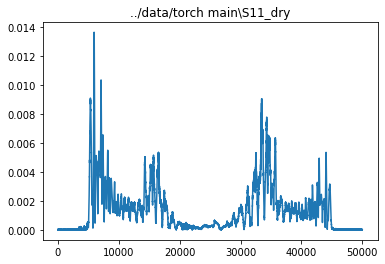

------------------------------------

The accuracy in TEST for ../data/torch main\S12_dry is: 
  1       2        3
[[1165.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1165


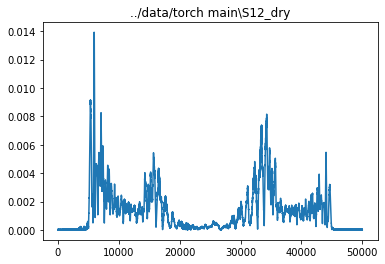

------------------------------------

The accuracy in TEST for ../data/torch main\S13_dry is: 
  1       2        3
[[916.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 0.00% 0/916


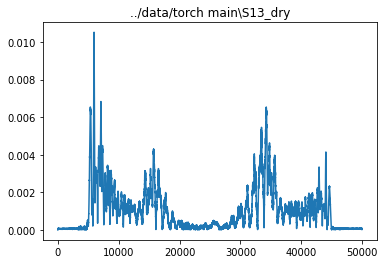

------------------------------------

The accuracy in TEST for ../data/torch main\S14_dry is: 
  1       2        3
[[1011.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1011


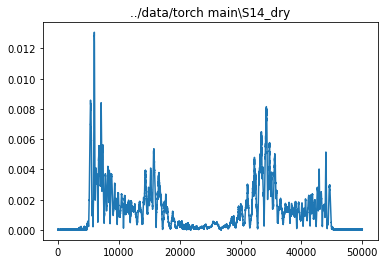

------------------------------------

The accuracy in TEST for ../data/torch main\S21_demi is: 
  1       2        3
[[   0.    0.    0.]
 [   0. 1226.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1226


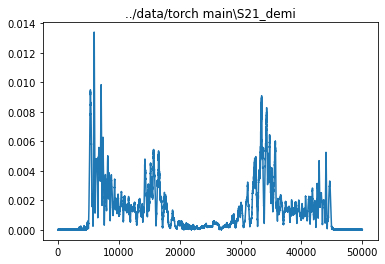

------------------------------------

The accuracy in TEST for ../data/torch main\S22_demi is: 
  1       2        3
[[   0.    0.    0.]
 [   0. 1082.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1082


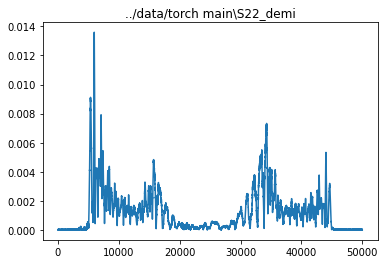

------------------------------------

The accuracy in TEST for ../data/torch main\S23_demi is: 
  1       2        3
[[  0.   0.   0.]
 [  0. 849.   0.]
 [  0.   0.   0.]]
Final Test error Net 0.00% 0/849


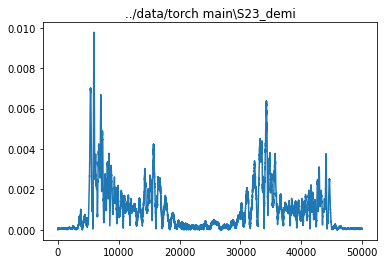

------------------------------------

The accuracy in TEST for ../data/torch main\S24_demi is: 
  1       2        3
[[   0.    0.    0.]
 [   0. 1639.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1639


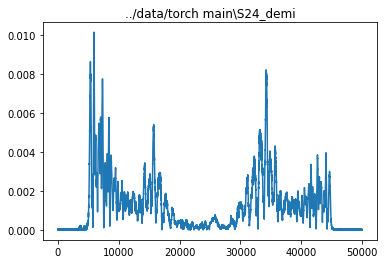

------------------------------------

The accuracy in TEST for ../data/torch main\S31_dry is: 
  1       2        3
[[834.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 0.00% 0/834


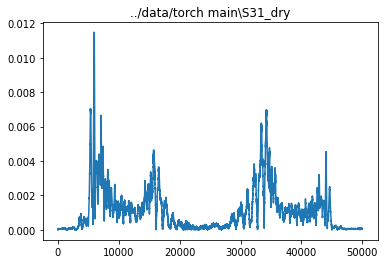

------------------------------------

The accuracy in TEST for ../data/torch main\S31_wet is: 
  1       2        3
[[   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0. 1463.]]
Final Test error Net 0.00% 0/1463


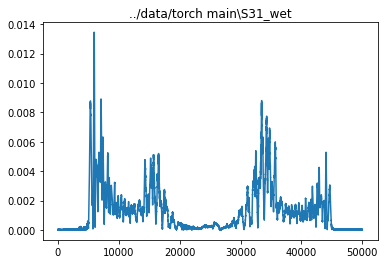

------------------------------------

The accuracy in TEST for ../data/torch main\S32_dry is: 
  1       2        3
[[1105.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1105


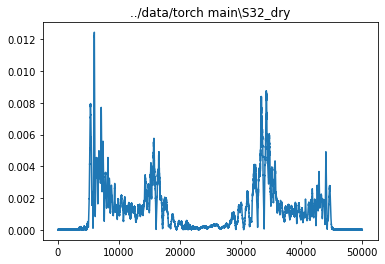

------------------------------------

The accuracy in TEST for ../data/torch main\S32_wet is: 
  1       2        3
[[   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0. 1482.]]
Final Test error Net 0.00% 0/1482


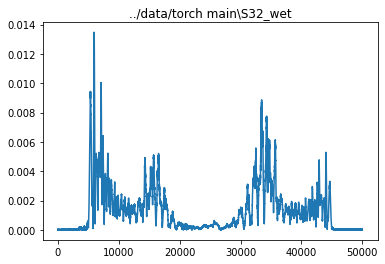

------------------------------------

The accuracy in TEST for ../data/torch main\S33_dry is: 
  1       2        3
[[988.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 0.00% 0/988


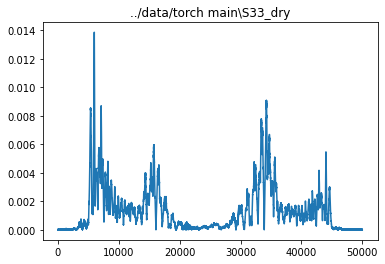

------------------------------------

The accuracy in TEST for ../data/torch main\S33_wet is: 
  1       2        3
[[   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0. 1491.]]
Final Test error Net 0.00% 0/1491


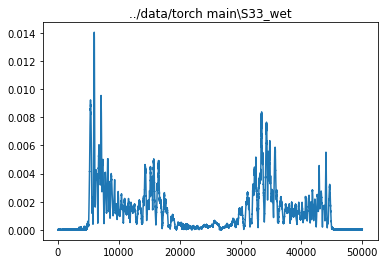

------------------------------------

The accuracy in TEST for ../data/torch main\S34_dry is: 
  1       2        3
[[1075.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1075


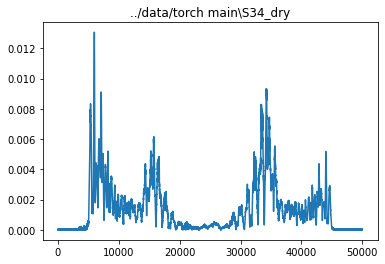

------------------------------------

The accuracy in TEST for ../data/torch main\S34_wet is: 
  1       2        3
[[   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0. 1306.]]
Final Test error Net 0.00% 0/1306


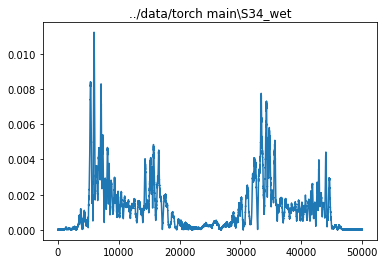

------------------------------------


In [14]:
for file in allFiles:
    print_conf(file)

In [15]:
path = '../data/torch test/'
allFiles = glob.glob(path + "/*")
allFiles

['../data/torch test\\demi',
 '../data/torch test\\dry',
 '../data/torch test\\S12_dry_test',
 '../data/torch test\\S13_dry_test',
 '../data/torch test\\S14_dry_test',
 '../data/torch test\\wet']


The accuracy in TEST for ../data/torch test\demi is: 
  1       2        3
[[  0.   0.   0.]
 [  0. 165.   0.]
 [  0.   0.   0.]]
Final Test error Net 0.00% 0/165


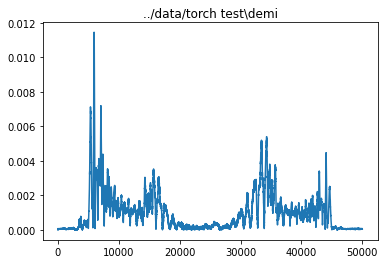

------------------------------------

The accuracy in TEST for ../data/torch test\dry is: 
  1       2        3
[[ 3.  0.  0.]
 [54.  0.  0.]
 [92.  0.  0.]]
Final Test error Net 97.99% 146/149


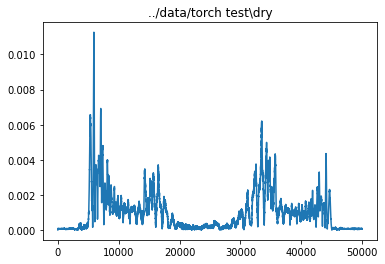

------------------------------------

The accuracy in TEST for ../data/torch test\S12_dry_test is: 
  1       2        3
[[  0.   0.   0.]
 [330.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 100.00% 330/330


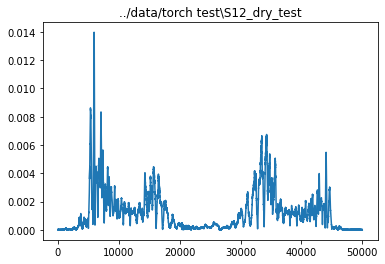

------------------------------------

The accuracy in TEST for ../data/torch test\S13_dry_test is: 
  1       2        3
[[  0.   0.   0.]
 [302.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 100.00% 302/302


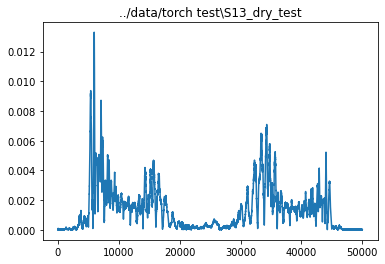

------------------------------------

The accuracy in TEST for ../data/torch test\S14_dry_test is: 
  1       2        3
[[  0.   0.   0.]
 [301.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 100.00% 301/301


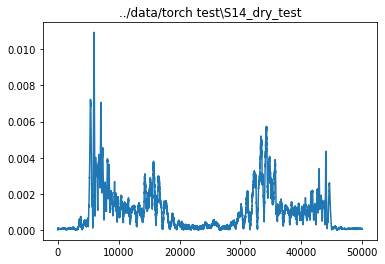

------------------------------------

The accuracy in TEST for ../data/torch test\wet is: 
  1       2        3
[[  0.   0.   0.]
 [  0.   0. 220.]
 [  0.   0.   0.]]
Final Test error Net 100.00% 220/220


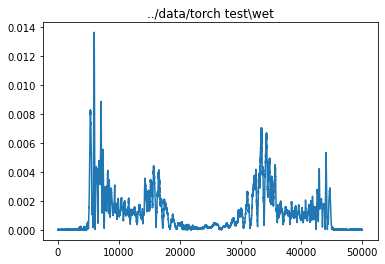

------------------------------------


In [16]:
for file in allFiles:
    print_conf(file)

In [17]:
path = '../data/torch wet/'
allFiles = glob.glob(path + "/*")
allFiles

['../data/torch wet\\S11_dry',
 '../data/torch wet\\S12_dry',
 '../data/torch wet\\S13_dry',
 '../data/torch wet\\S14_dry',
 '../data/torch wet\\S31_wet',
 '../data/torch wet\\S32_wet',
 '../data/torch wet\\S33_wet',
 '../data/torch wet\\S34_wet']


The accuracy in TEST for ../data/torch wet\S11_dry is: 
  1       2        3
[[1079.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1079


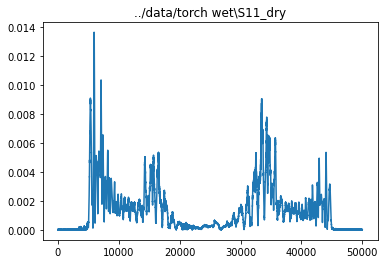

------------------------------------

The accuracy in TEST for ../data/torch wet\S12_dry is: 
  1       2        3
[[1165.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1165


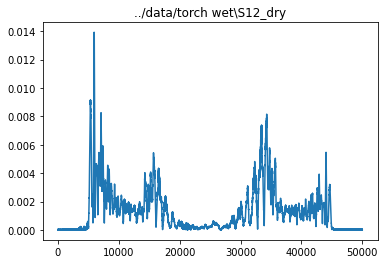

------------------------------------

The accuracy in TEST for ../data/torch wet\S13_dry is: 
  1       2        3
[[916.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 0.00% 0/916


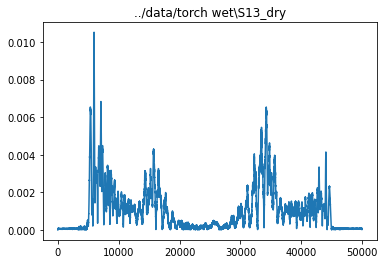

------------------------------------

The accuracy in TEST for ../data/torch wet\S14_dry is: 
  1       2        3
[[1011.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1011


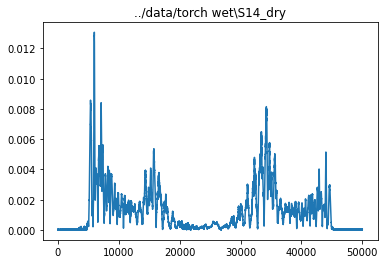

------------------------------------

The accuracy in TEST for ../data/torch wet\S31_wet is: 
  1       2        3
[[   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0. 1152.]]
Final Test error Net 0.00% 0/1152


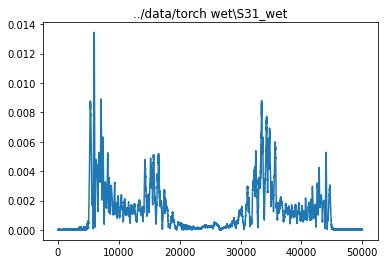

------------------------------------

The accuracy in TEST for ../data/torch wet\S32_wet is: 
  1       2        3
[[   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0. 1225.]]
Final Test error Net 0.00% 0/1225


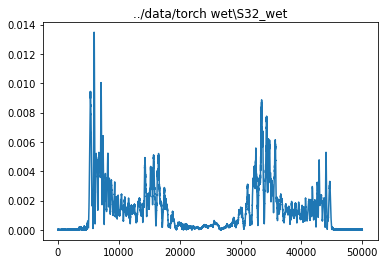

------------------------------------

The accuracy in TEST for ../data/torch wet\S33_wet is: 
  1       2        3
[[   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0. 1185.]]
Final Test error Net 0.00% 0/1185


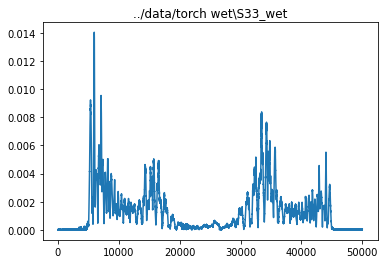

------------------------------------

The accuracy in TEST for ../data/torch wet\S34_wet is: 
  1       2        3
[[   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0. 1000.]]
Final Test error Net 0.00% 0/1000


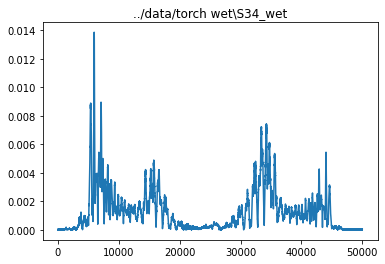

------------------------------------


In [18]:
for file in allFiles:
    print_conf(file)

In [19]:
path = '../data/torch bias/'
allFiles = glob.glob(path + "/*")
allFiles

['../data/torch bias\\S11_dry',
 '../data/torch bias\\S12_dry',
 '../data/torch bias\\S13_dry',
 '../data/torch bias\\S14_dry',
 '../data/torch bias\\S21_dry',
 '../data/torch bias\\S22_dry',
 '../data/torch bias\\S23_dry',
 '../data/torch bias\\S24_dry',
 '../data/torch bias\\S31_dry',
 '../data/torch bias\\S32_dry',
 '../data/torch bias\\S33_dry',
 '../data/torch bias\\S34_dry']


The accuracy in TEST for ../data/torch bias\S11_dry is: 
  1       2        3
[[1050.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1050


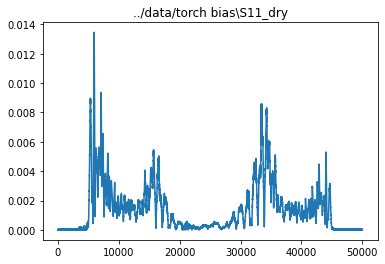

------------------------------------

The accuracy in TEST for ../data/torch bias\S12_dry is: 
  1       2        3
[[1055.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1055


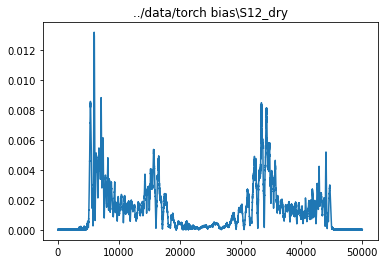

------------------------------------

The accuracy in TEST for ../data/torch bias\S13_dry is: 
  1       2        3
[[1353.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1353


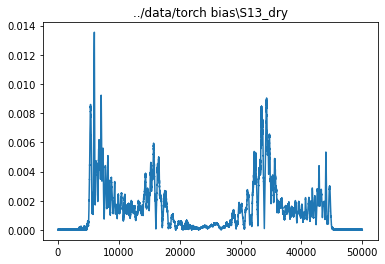

------------------------------------

The accuracy in TEST for ../data/torch bias\S14_dry is: 
  1       2        3
[[1021.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1021


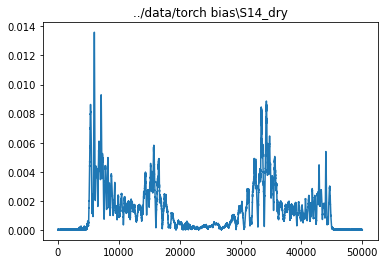

------------------------------------

The accuracy in TEST for ../data/torch bias\S21_dry is: 
  1       2        3
[[290.   0.   0.]
 [  0.   0.   0.]
 [703.   0.   0.]]
Final Test error Net 70.80% 703/993


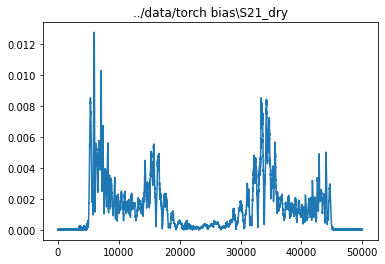

------------------------------------

The accuracy in TEST for ../data/torch bias\S22_dry is: 
  1       2        3
[[1050.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1050


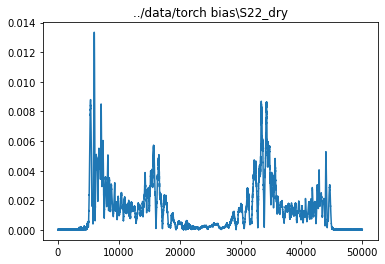

------------------------------------

The accuracy in TEST for ../data/torch bias\S23_dry is: 
  1       2        3
[[1024.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1024


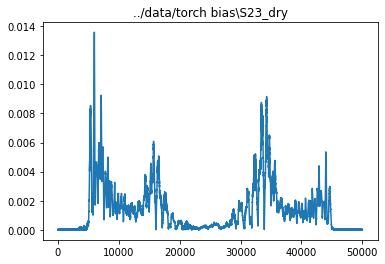

------------------------------------

The accuracy in TEST for ../data/torch bias\S24_dry is: 
  1       2        3
[[  7.   0.   0.]
 [  0.   0.   0.]
 [967.   0.   0.]]
Final Test error Net 99.28% 967/974


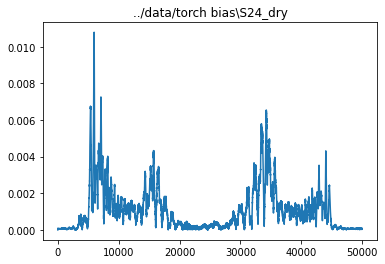

------------------------------------

The accuracy in TEST for ../data/torch bias\S31_dry is: 
  1       2        3
[[834.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 0.00% 0/834


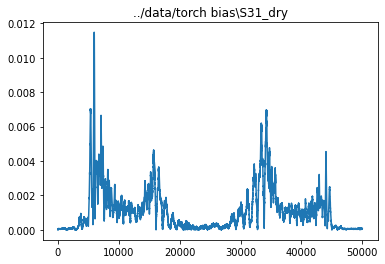

------------------------------------

The accuracy in TEST for ../data/torch bias\S32_dry is: 
  1       2        3
[[1105.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1105


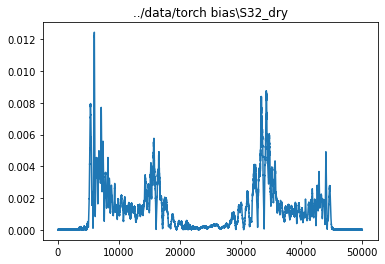

------------------------------------

The accuracy in TEST for ../data/torch bias\S33_dry is: 
  1       2        3
[[988.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]
Final Test error Net 0.00% 0/988


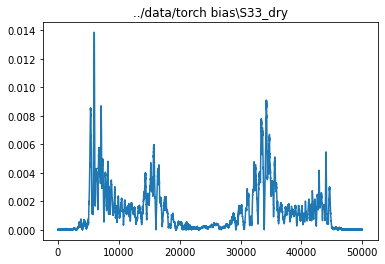

------------------------------------

The accuracy in TEST for ../data/torch bias\S34_dry is: 
  1       2        3
[[1075.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
Final Test error Net 0.00% 0/1075


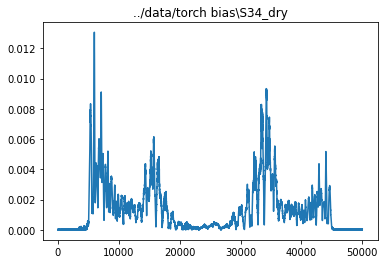

------------------------------------


In [20]:
for file in allFiles:
    print_conf(file)